# Get uncertainty of data far beyond training data 
This experiment only uses the original kind of data, but tries to predict far beyond this known data.

Original experiment[1] only provides data at [0,1] and previous experiments show it seems to work in that interval, showing how uncertainty follows the variance of the data. But, what happen when we try to predict far away fron known data. An intuitive idea is that as you walk away from known data the uncertainty should increase.

However, we don't know what could the output: uncertainty reaches a maximum and remains stable? uncertainty increase exponentially? linearly? should it be infinity at some point?

This technique is no set explicitly for a behaviour in this context, so we don't know what could be its behaviour and if it is correct from some point of view.

hipothesis: variance should increase as long as it is away from trainign data, since uncertainty increase being far from known data.


[1] Original at: https://github.com/sthorn/deep-learning-explorations/blob/master/predicting-uncertainty.ipynb

# Predicting uncertainty with (deep) neural networks

The original method is as follows:
The idea is that a network that outputs a real-valued prediction can be (simply) modified to provide an estimate of the error on this prediction. Roughly speaking we do:

* Add an additional real-valued output to the network. The network now predicts two values: the output, $y$, and its error, $\sigma$

* Estimate the target value for the error, $\sigma$, from the difference between the target value of the output, $y$, and its predicted value, $\hat{y}$. We can use either: $\sigma^2 = (y-\hat{y})^2$ or $\sigma = \left| y-\hat{y}\right|$

* An easy way to do this at training time is with a customised loss function



### Imports 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as m
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import copy

%matplotlib inline

### Generate some random data

In [3]:
# Generate some linearly related data
n_samples = 10000
np.random.seed(4567)

In [5]:
x = np.random.random(n_samples)                      
eps = np.random.normal(scale=1.0, size=n_samples) * 0.4*np.sin(x*4*np.pi)
y = 2*x + 1 + eps

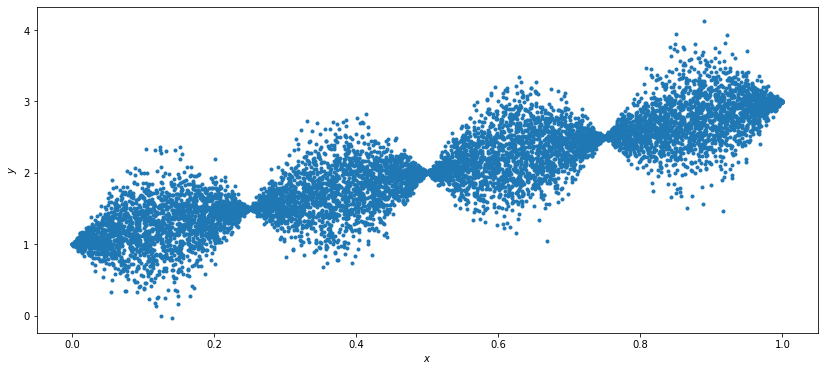

In [6]:
# Plot the data
plt.figure(figsize=(14,6))
plt.plot(x, y, '.')
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');

In [9]:
# Add in column of dummy zeros to represent sigma 
sigma = np.zeros(n_samples)
y = np.stack([y, sigma], axis=1)

In [11]:
# Reshape x for PyTorch
x = x.reshape(n_samples, 1)

# ¡¡WARNING!!
This is a experiment, we don't know the correct output. So we can't validate the output, and, indeed, we can't use validation data to validate the output. So don't make the split between training and validation.

In [12]:
# Split into training and validation sets
#n_validation = 500
#x_val, x = x[:n_validation], x[n_validation:]
#y_val, y = y[:n_validation], y[n_validation:]

In [13]:
# Convert x and y to PyTorch Variables on the GPU
dtype = torch.FloatTensor
x = Variable(torch.from_numpy(x).type(dtype))
y = Variable(torch.from_numpy(y).type(dtype), requires_grad=False)

In [14]:
# Check shape ok for PyTorch - x should be (n x 1), y (n x 2)
x.shape, y.shape

(torch.Size([10000, 1]), torch.Size([10000, 2]))

### Create a simple network 

In [15]:
# Create a simple two-layer network with one input (x) and two outputs (y, sigma)
n_inputs = 1
n_outputs = 2
n_hidden = 1000
model = torch.nn.Sequential(torch.nn.Linear(n_inputs, n_hidden),
                            torch.nn.ReLU(),
                            torch.nn.Linear(n_hidden, n_outputs)
                           )

In [16]:
# Adam optimizer
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Custom loss function
This is where the magic happens.

In [17]:
def custom_loss(input, target):
    
    # Estimate target value for sigma with abs(y_pred - y)
    #
    #    actual y     is target[:,0]
    # predicted y     is input[:,0]
    #    actual sigma is target[:,1]
    # predicted sigma is input[:,1]
    
    # Use 'requires_grad == False' to prevent PyTorch from trying to differentiate 'target'
    target[:,1] = Variable((input[:,0].data - target[:,0].data).abs(), 
                           requires_grad=False)  
    # Return MSE loss 
    return F.mse_loss(input, target)

### Training loop 
We train this simple model with batch size equal to the whole dataset.

In [18]:
n_epochs = 10000
for i in range(n_epochs):
    
    # Calculate predicted y from x
    y_pred = model(x)
    
    # Calculate loss
    loss = custom_loss(y_pred, y)
    
    if i%500 == 0: print(f'epoch: {i:4}, loss: {loss.data:.3}',)

    # Backprop, first zeroing gradients
    optimizer.zero_grad()
    loss.backward()

    # Update parameters
    optimizer.step()

epoch:    0, loss: 4.22
epoch:  500, loss: 0.0619
epoch: 1000, loss: 0.0615
epoch: 1500, loss: 0.0613
epoch: 2000, loss: 0.061
epoch: 2500, loss: 0.0608
epoch: 3000, loss: 0.0605
epoch: 3500, loss: 0.0602
epoch: 4000, loss: 0.0599
epoch: 4500, loss: 0.0596
epoch: 5000, loss: 0.0593
epoch: 5500, loss: 0.059
epoch: 6000, loss: 0.0586
epoch: 6500, loss: 0.0583
epoch: 7000, loss: 0.058
epoch: 7500, loss: 0.0576
epoch: 8000, loss: 0.0573
epoch: 8500, loss: 0.0571
epoch: 9000, loss: 0.0568
epoch: 9500, loss: 0.0567


### Get predictions for data beyond training

In [82]:


#X for predicting data beyond training interval
x_far_away=np.arange(0.0,1199.0,10)
x_far_away=x_far_away.reshape(int(1200/10), 1)
#X for predicting data beyond training interval with fine grain
x_far_away_fg=np.arange(1199,1200.0,0.01)
x_far_away_fg=x_far_away_fg.reshape(100, 1)

#Predicting inside training interval too in order to validate it learns from data
x_trained_interval=np.arange(0.0,1.0,0.01)
x_trained_interval=x_trained_interval.reshape(100, 1)
x_to_predict=np.concatenate((x_trained_interval,x_far_away,x_far_away_fg))

x_val_pytorch = Variable(torch.from_numpy(x_to_predict).type(dtype)) 
pred = model(x_val_pytorch)
y_pred = pred[:,0].cpu().data
sigma_pred = pred[:,1].cpu().data


### Plot results

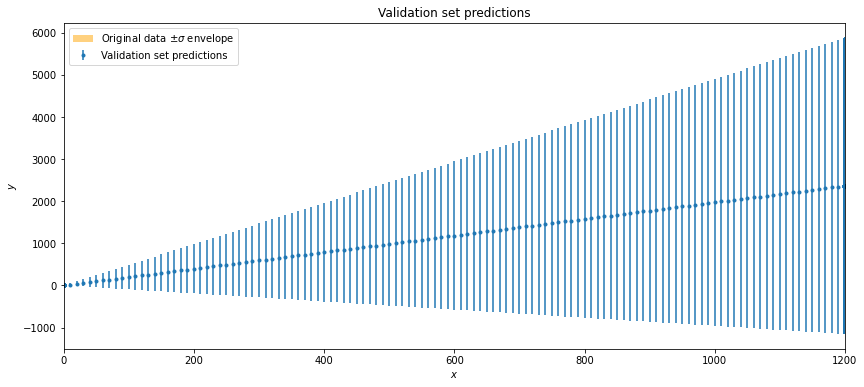

In [83]:
# Plot predictions and their errors
plt.figure(figsize=(14,6))
plt.errorbar(x_to_predict, y_pred, yerr=sigma_pred, fmt='.');
#plt.errorbar(x_val, y_pred, fmt='.');
# One standard-deviation envelope
xs = np.linspace(0.0, 1.0, 50)
err = 0.4*np.sin(xs*4*np.pi)
plt.fill_between(xs, 2*xs+1-err, 2*xs+1+err, facecolor='orange', alpha=0.5, edgecolor='none');
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.xlim(0,1200);
plt.title('Validation set predictions');
plt.legend([r'Original data $\pm \sigma$ envelope','Validation set predictions'], loc='upper left', );

The result shows how uncertainty increase along x axis. It seems to be increased linearly. 

If we make zoom in the first points:

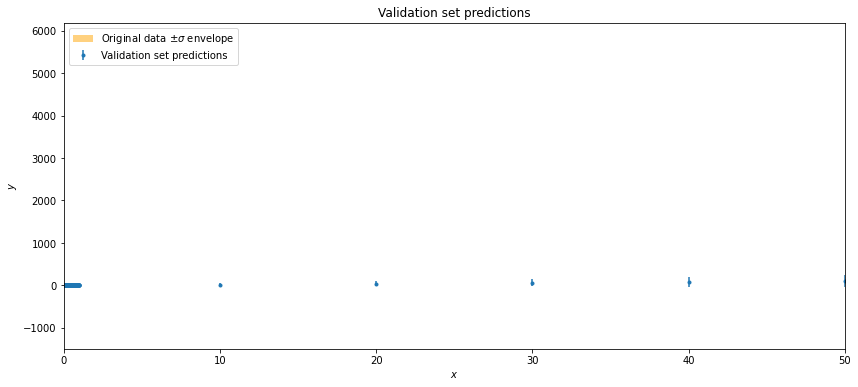

In [63]:
plt.figure(figsize=(14,6))
plt.errorbar(x_to_predict, y_pred, yerr=sigma_pred, fmt='.');
plt.fill_between(xs, 2*xs+1-err, 2*xs+1+err, facecolor='orange', alpha=0.5, edgecolor='none');
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.xlim(0,50);
plt.title('Validation set predictions');
plt.legend([r'Original data $\pm \sigma$ envelope','Validation set predictions'], loc='upper left', );

We can see how uncertainty is increased.


Making zoom in training interval:

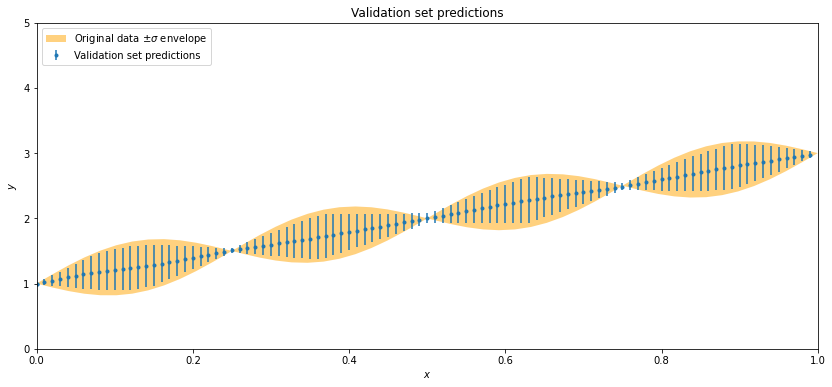

In [80]:
plt.figure(figsize=(14,6))
plt.errorbar(x_to_predict, y_pred, yerr=sigma_pred, fmt='.');
plt.fill_between(xs, 2*xs+1-err, 2*xs+1+err, facecolor='orange', alpha=0.5, edgecolor='none');
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.xlim(0,1);
plt.ylim(0,5);
plt.title('Validation set predictions');
plt.legend([r'Original data $\pm \sigma$ envelope','Validation set predictions'], loc='upper left', );

So the original sine form is learnt in training interval and uncertainty is still 

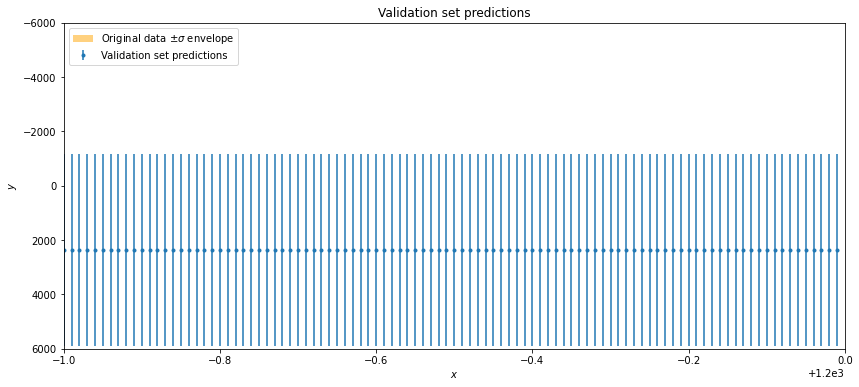

In [88]:
plt.figure(figsize=(14,6))
plt.errorbar(x_to_predict, y_pred, yerr=sigma_pred, fmt='.');
plt.fill_between(xs, 2*xs+1-err, 2*xs+1+err, facecolor='orange', alpha=0.5, edgecolor='none');
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.xlim(1199,1200);
plt.ylim(6000,-6000)
plt.title('Validation set predictions');
plt.legend([r'Original data $\pm \sigma$ envelope','Validation set predictions'], loc='upper left', );

 The model only has learnt the lineral component, but not the sine shape. Specificly the following component:

In [78]:
print (str(float(y_pred[0]))+"+"+str(float(y_pred[219])/float(x_to_predict[219]))+"X")

0.9978438019752502+1.973022255777311X


That is the "y = 2*x + 1 + eps" of the generation data section, as we could expect.

The incertainty increases linearly along the following slope, we don't know why:

In [90]:
float(sigma_pred[219])/float(x_to_predict[219])

-2.9343624852284664

# Conclusions

Initially, the result is the expected result for this data: the uncertainty is increased as long as the prediction is far away from known data.

However, **it increases linearly and this can't be explained**. Besides, the model **learns the sine shape** in training data, but not beyond that point, so **it can be overfitting** for that data.

So,the model behaviour is some kind of expected, but the **results are not conclusive** about its behaviour in any situation. 

